In [ ]:
# Install spaCy English language model
import subprocess
import sys

print("Installing spaCy English language model...")
try:
    result = subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], 
                          capture_output=True, text=True)
    print("Installation output:", result.stdout)
    if result.stderr:
        print("Installation errors:", result.stderr)
    
    if result.returncode == 0:
        print("✅ spaCy English model installed successfully!")
    else:
        print("❌ Installation failed")
        
except Exception as e:
    print(f"❌ Error during installation: {e}")
    
print("Installation complete. Ready to proceed with NLP analysis.")

# Task 3: NLP with spaCy - Amazon Product Reviews Analysis

In this notebook, we'll analyze Amazon product reviews using spaCy to:
1. Perform named entity recognition (NER) to extract product names and brands
2. Analyze sentiment (positive/negative) using a rule-based approach

## About the Task
Natural Language Processing (NLP) is a key component of AI that enables machines to understand, interpret, and generate human language. In this task, we'll use spaCy, a powerful and efficient NLP library, to analyze product reviews.

## 1. Import Required Libraries

First, let's import all the libraries we'll need for our NLP analysis.

In [3]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set up the plotting style
plt.style.use('seaborn-v0_8')

## 2. Load and Set Up spaCy

We'll load spaCy's English language model and check that it's working properly.

In [4]:
# Load English language model
try:
    nlp = spacy.load("en_core_web_sm")
    print("✅ Successfully loaded spaCy English model")
    
    # Check the model's capabilities
    print("\nModel capabilities:")
    print(f"- Named Entity Recognition (NER): {'ner' in nlp.pipe_names}")
    print(f"- Part-of-speech tagging: {'tagger' in nlp.pipe_names}")
    print(f"- Dependency parsing: {'parser' in nlp.pipe_names}")
    print(f"- Word vectors: {nlp.vocab.vectors_length > 0}")
    
except OSError:
    print("❌ spaCy English model not found. Please install it with:")
    print("python -m spacy download en_core_web_sm")

✅ Successfully loaded spaCy English model

Model capabilities:
- Named Entity Recognition (NER): True
- Part-of-speech tagging: True
- Dependency parsing: True
- Word vectors: False


## 3. Create Sample Amazon Reviews Dataset

For this exercise, we'll create a sample dataset of Amazon product reviews. In a real-world scenario, you would load this data from an external source or API.

In [5]:
# Create sample Amazon product reviews for demonstration
sample_reviews = [
    "I absolutely love my new iPhone 14 Pro from Apple! The camera quality is amazing and the battery life is fantastic. Highly recommend this product.",
    "The Samsung Galaxy S23 is decent but the price is too high. The display is beautiful but I expected better performance for the cost.",
    "These Nike Air Max shoes are incredibly comfortable. Perfect for running and daily wear. Great quality from Nike as always.",
    "Bought this Sony PlayStation 5 and it's amazing! The graphics are stunning and the games load so fast. Sony really outdid themselves.",
    "The MacBook Pro M2 from Apple is a powerhouse. Perfect for video editing and programming. The build quality is excellent as expected from Apple.",
    "These Adidas sneakers are okay but not great. The design is nice but they're not as comfortable as my previous Nike shoes.",
    "Love my new AirPods Pro! The noise cancellation is incredible. Apple continues to make amazing products.",
    "The Dell laptop I bought has been disappointing. Poor build quality and the screen is not bright enough. Would not recommend Dell products.",
    "This Kindle from Amazon is perfect for reading. The battery lasts forever and the screen is easy on the eyes. Great product from Amazon.",
    "The Google Pixel 7 camera is outstanding! The night mode is incredible. Google has really improved their smartphone camera technology.",
    "My new Tesla Model 3 is absolutely incredible! The autopilot feature is amazing and the battery range is impressive. Tesla is the future!",
    "Disappointed with this Microsoft Surface Pro. The keyboard is flimsy and the performance is not as advertised. Expected better from Microsoft.",
    "The Canon EOS R5 camera is a beast! Perfect for professional photography. The image quality is unmatched. Canon makes the best cameras.",
    "These Bose headphones are worth every penny. The sound quality is phenomenal and the noise cancellation is top-notch. Bose is the best!",
    "The LG OLED TV has stunning picture quality. The colors are vibrant and the contrast is perfect. LG makes excellent televisions.",
    "Not happy with this HP printer. It's slow and the print quality is poor. Had better experience with Canon printers.",
    "The Rolex Submariner is a masterpiece! The craftsmanship is incredible and it keeps perfect time. Rolex is truly luxury at its finest.",
    "This BMW X5 is a fantastic SUV. The driving experience is smooth and the interior is luxurious. BMW engineering is outstanding.",
    "The Nintendo Switch is perfect for gaming on the go. Great game library and the portability is excellent. Nintendo knows how to make fun consoles.",
    "Disappointed with this Fitbit tracker. The battery life is poor and the app is buggy. My previous Garmin device was much better."
]

# Create DataFrame for better organization
reviews_df = pd.DataFrame({
    'review_id': range(1, len(sample_reviews) + 1),
    'review_text': sample_reviews
})

print(f"Created dataset with {len(sample_reviews)} sample reviews")
print("\nFirst 5 reviews:")
reviews_df.head()

Created dataset with 20 sample reviews

First 5 reviews:


First 5 reviews:


,review_id,review_text
0,1,I absolutely love my new iPhone 14 Pro from Ap...
1,2,The Samsung Galaxy S23 is decent but the price...
2,3,These Nike Air Max shoes are incredibly comfor...
3,4,Bought this Sony PlayStation 5 and it's amazin...
4,5,The MacBook Pro M2 from Apple is a powerhouse....


## 4. Basic Text Analysis

Before diving into NER and sentiment analysis, let's do some basic text analysis to understand our data better.

Review text statistics:
- Average word count: 21.95 words per review
- Average character count: 132.00 characters per review
- Shortest review: 16 words
- Longest review: 25 words


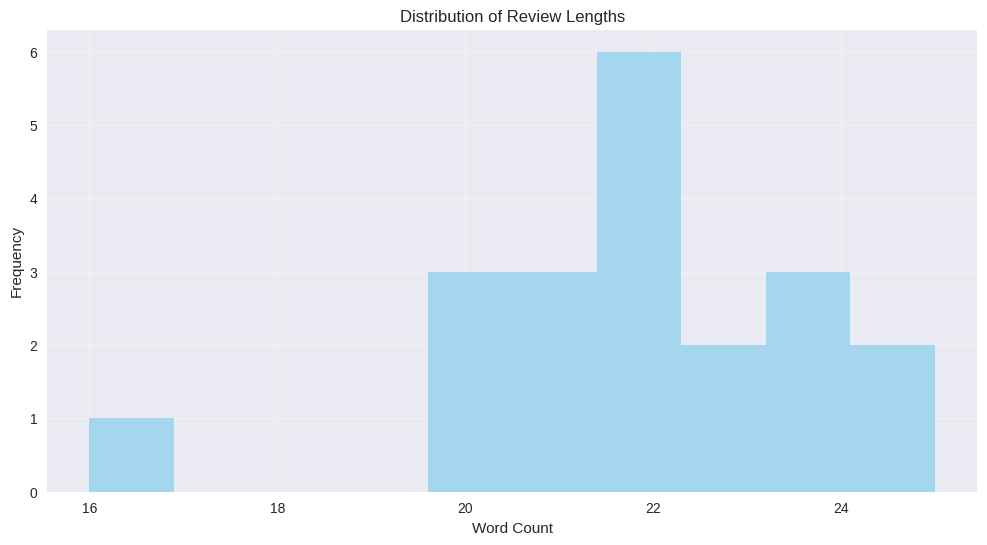

In [6]:
# Calculate basic text statistics
reviews_df['word_count'] = reviews_df['review_text'].apply(lambda x: len(x.split()))
reviews_df['char_count'] = reviews_df['review_text'].apply(len)

print("Review text statistics:")
print(f"- Average word count: {reviews_df['word_count'].mean():.2f} words per review")
print(f"- Average character count: {reviews_df['char_count'].mean():.2f} characters per review")
print(f"- Shortest review: {reviews_df['word_count'].min()} words")
print(f"- Longest review: {reviews_df['word_count'].max()} words")

# Distribution of review lengths
plt.figure(figsize=(12, 6))
plt.hist(reviews_df['word_count'], bins=10, alpha=0.7, color='skyblue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

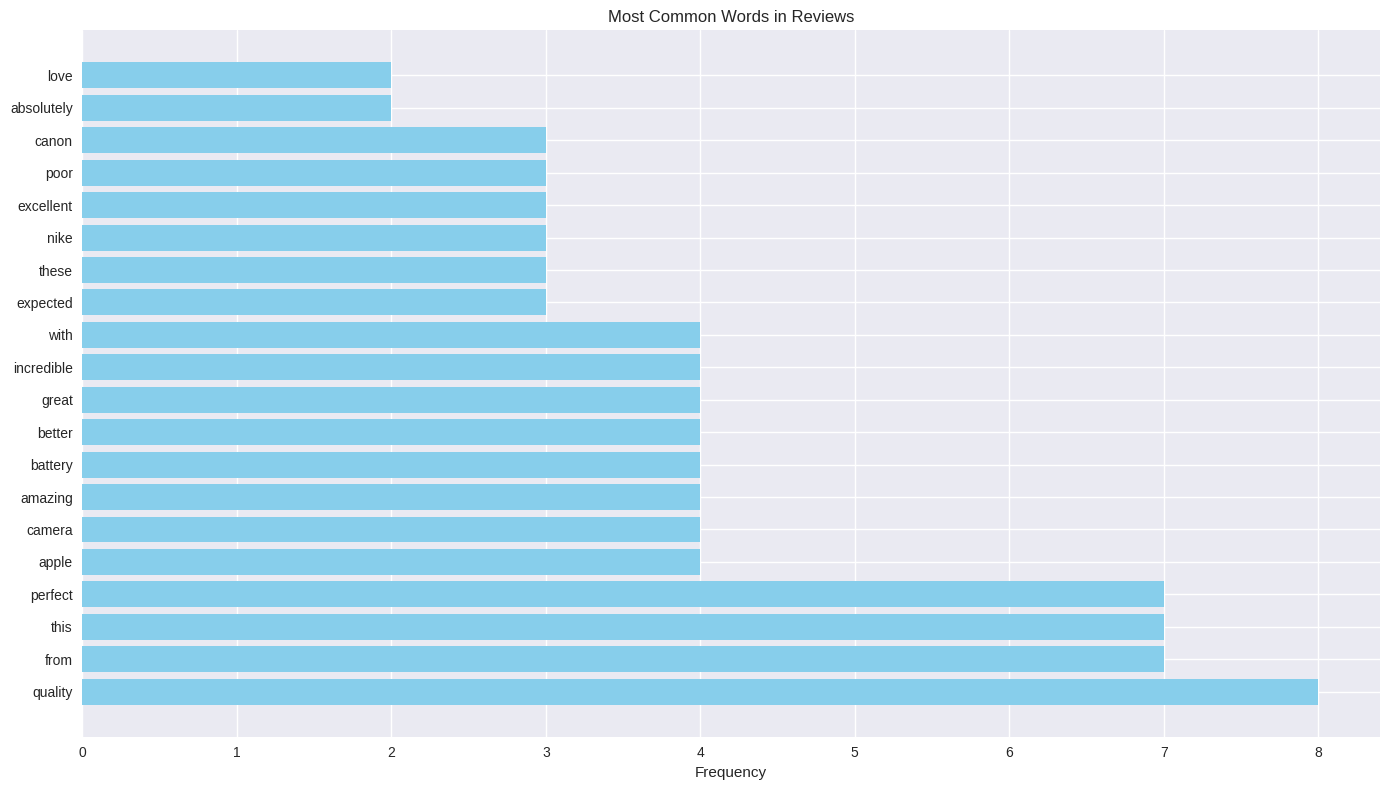

In [7]:
# Most common words (excluding stopwords)
from collections import Counter
import re

def extract_words(text):
    # Convert to lowercase and extract words
    words = re.findall(r'\b\w+\b', text.lower())
    # Filter out short words (likely to be stopwords)
    return [word for word in words if len(word) > 3]

all_words = []
for review in reviews_df['review_text']:
    all_words.extend(extract_words(review))

word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

# Plot most common words
plt.figure(figsize=(14, 8))
words, counts = zip(*most_common_words)
y_pos = np.arange(len(words))
plt.barh(y_pos, counts, align='center', color='skyblue')
plt.yticks(y_pos, words)
plt.xlabel('Frequency')
plt.title('Most Common Words in Reviews')
plt.tight_layout()
plt.show()

## 5. Named Entity Recognition (NER)

Now let's use spaCy's NER capabilities to extract product names and brands from the reviews.

In [8]:
# Function to extract entities from a review
def extract_entities(text):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        entities.append({
            'text': ent.text,
            'label': ent.label_,
            'description': spacy.explain(ent.label_)
        })
    return entities

# Apply entity extraction to all reviews
reviews_df['entities'] = reviews_df['review_text'].apply(extract_entities)

# Print an example
print("Example of entity extraction:")
sample_idx = 0
print(f"\nReview: {reviews_df['review_text'][sample_idx]}")
print("\nExtracted entities:")
for ent in reviews_df['entities'][sample_idx]:
    print(f"- {ent['text']} ({ent['label']}: {ent['description']})")

# Analyze extracted entities
all_entities = []
for entities in reviews_df['entities']:
    all_entities.extend(entities)

print(f"\nTotal entities found: {len(all_entities)}")
entity_types = Counter([ent['label'] for ent in all_entities])
print("\nEntity types found:")
for ent_type, count in entity_types.most_common():
    print(f"- {ent_type} ({spacy.explain(ent_type)}): {count}")

Example of entity extraction:

Review: I absolutely love my new iPhone 14 Pro from Apple! The camera quality is amazing and the battery life is fantastic. Highly recommend this product.

Extracted entities:
- 14 (CARDINAL: Numerals that do not fall under another type)
- Apple (ORG: Companies, agencies, institutions, etc.)

Total entities found: 29

Entity types found:
- ORG (Companies, agencies, institutions, etc.): 20
- PERSON (People, including fictional): 3
- PRODUCT (Objects, vehicles, foods, etc. (not services)): 2
- CARDINAL (Numerals that do not fall under another type): 1
- TIME (Times smaller than a day): 1
- MONEY (Monetary values, including unit): 1
- NORP (Nationalities or religious or political groups): 1


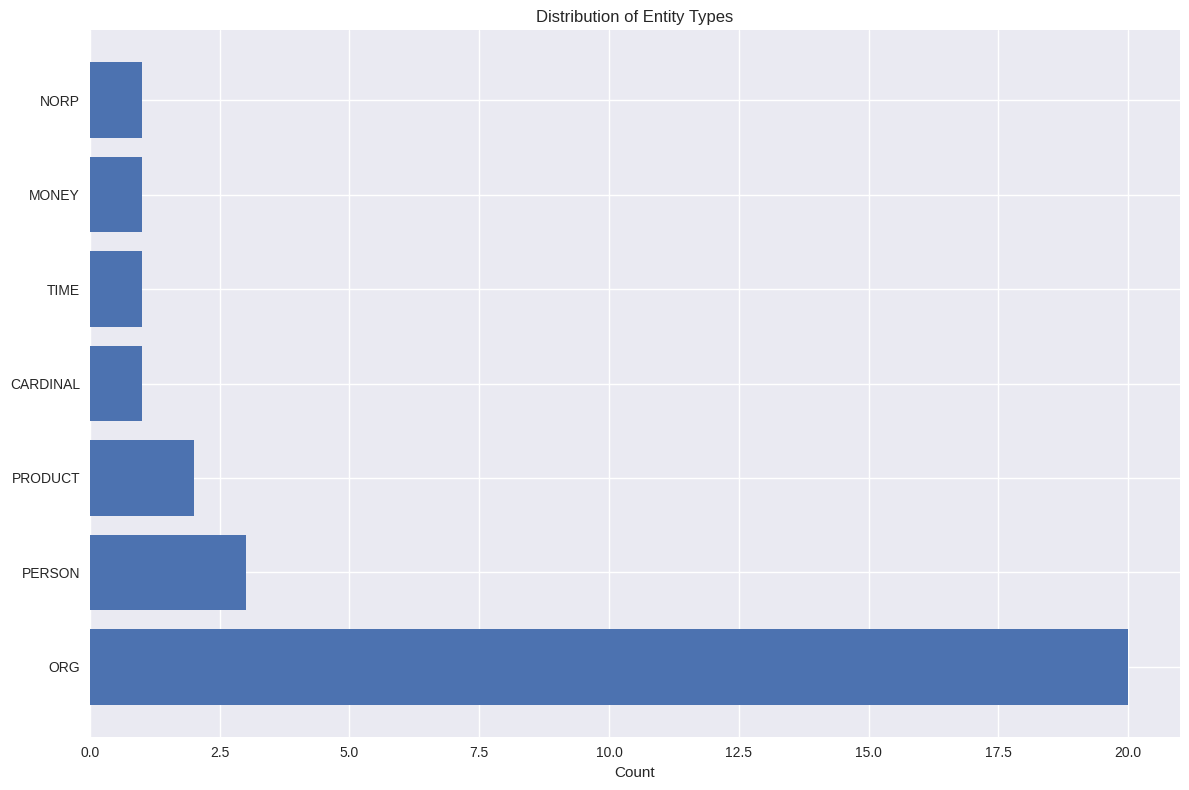

In [9]:
# Visualize entity types
plt.figure(figsize=(12, 8))
labels, counts = zip(*entity_types.most_common())
plt.barh(range(len(counts)), counts, tick_label=labels)
plt.title('Distribution of Entity Types')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

## 6. Enhanced Product and Brand Extraction with Pattern Matching

While spaCy's NER is powerful, it might not catch all product names and brands in our specific domain. Let's supplement it with pattern matching to improve our extraction.

In [10]:
# Define patterns for brands and products
brand_patterns = [
    r'\b(Apple|Samsung|Sony|Nike|Adidas|Google|Microsoft|Amazon|Tesla|Canon|Bose|LG|HP|Rolex|BMW|Nintendo|Fitbit|Garmin|Dell)\b',
]

product_patterns = [
    r'\b(iPhone|Galaxy|PlayStation|MacBook|AirPods|Kindle|Pixel|Model [0-9]|Surface|EOS|Submariner|Switch)\b',
    r'\b[A-Z][a-z]+ [A-Z][a-z]+ [0-9]+\b',  # Product with model number
    r'\b[A-Z][a-z]+ [A-Z][0-9]+\b',  # Product with alphanumeric model
]

def extract_with_patterns(text):
    extracted_brands = set()
    extracted_products = set()
    
    # Extract brands
    for pattern in brand_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        extracted_brands.update(matches)
    
    # Extract products
    for pattern in product_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        extracted_products.update(matches)
    
    return {
        'brands': list(extracted_brands),
        'products': list(extracted_products)
    }

# Apply pattern-based extraction
reviews_df['pattern_extraction'] = reviews_df['review_text'].apply(extract_with_patterns)

# Example of pattern-based extraction
print("Example of pattern-based extraction:")
sample_idx = 0
print(f"\nReview: {reviews_df['review_text'][sample_idx]}")
print(f"\nExtracted brands: {reviews_df['pattern_extraction'][sample_idx]['brands']}")
print(f"Extracted products: {reviews_df['pattern_extraction'][sample_idx]['products']}")

# Collect all extracted brands and products
all_brands = set()
all_products = set()

for extraction in reviews_df['pattern_extraction']:
    all_brands.update(extraction['brands'])
    all_products.update(extraction['products'])

print(f"\nAll extracted brands: {sorted(all_brands)}")
print(f"All extracted products: {sorted(all_products)}")

Example of pattern-based extraction:

Review: I absolutely love my new iPhone 14 Pro from Apple! The camera quality is amazing and the battery life is fantastic. Highly recommend this product.

Extracted brands: ['Apple']
Extracted products: ['iPhone', 'new iPhone 14']

All extracted brands: ['Adidas', 'Amazon', 'Apple', 'BMW', 'Bose', 'Canon', 'Dell', 'Fitbit', 'Garmin', 'Google', 'HP', 'LG', 'Microsoft', 'Nike', 'Nintendo', 'Rolex', 'Samsung', 'Sony', 'Tesla']
All extracted products: ['AirPods', 'BMW X5', 'EOS', 'EOS R5', 'Galaxy', 'Galaxy S23', 'Google Pixel 7', 'Kindle', 'MacBook', 'Model 3', 'Pixel', 'PlayStation', 'Pro M2', 'Sony PlayStation 5', 'Submariner', 'Surface', 'Switch', 'Tesla Model 3', 'iPhone', 'new iPhone 14']


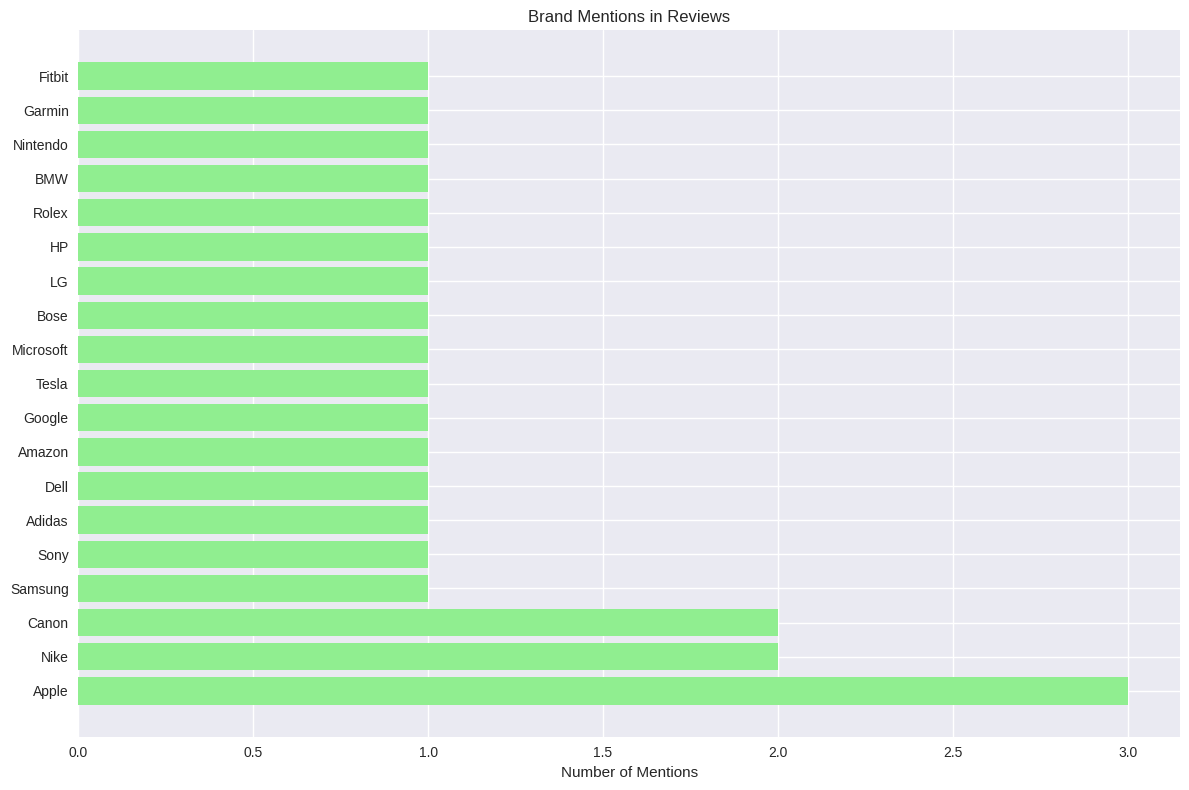

In [11]:
# Analyze brand mentions
brand_mentions = Counter()
for review in reviews_df['review_text']:
    for brand in all_brands:
        if brand.lower() in review.lower():
            brand_mentions[brand] += 1

# Plot brand mentions
plt.figure(figsize=(12, 8))
brands, counts = zip(*brand_mentions.most_common())
y_pos = np.arange(len(brands))
plt.barh(y_pos, counts, align='center', color='lightgreen')
plt.yticks(y_pos, brands)
plt.xlabel('Number of Mentions')
plt.title('Brand Mentions in Reviews')
plt.tight_layout()
plt.show()

## 7. Sentiment Analysis using Rule-Based Approach

Now let's analyze the sentiment of each review using a rule-based approach. We'll use a combination of:
1. Custom sentiment lexicons (positive/negative word lists)
2. TextBlob for comparison

In [12]:
# Define sentiment lexicons
positive_words = {
    'love', 'amazing', 'fantastic', 'excellent', 'great', 'perfect', 'outstanding',
    'incredible', 'wonderful', 'awesome', 'brilliant', 'superb', 'magnificent',
    'phenomenal', 'impressive', 'recommend', 'best', 'good', 'beautiful'
}

negative_words = {
    'hate', 'terrible', 'awful', 'horrible', 'disappointing', 'poor', 'bad',
    'worst', 'disappointing', 'flimsy', 'slow', 'buggy', 'expensive', 'not happy',
    'not recommend', 'not good', 'not great', 'not worth', 'waste'
}

def analyze_sentiment_rule_based(text):
    # Process with spaCy
    doc = nlp(text)
    
    # Rule-based sentiment scoring
    positive_score = 0
    negative_score = 0
    positive_matches = []
    negative_matches = []
    
    for token in doc:
        word = token.lemma_.lower()
        if word in positive_words:
            positive_score += 1
            positive_matches.append(token.text)
        elif word in negative_words:
            negative_score += 1
            negative_matches.append(token.text)
    
    # Calculate sentiment using TextBlob for comparison
    blob = TextBlob(text)
    textblob_polarity = blob.sentiment.polarity
    textblob_subjectivity = blob.sentiment.subjectivity
    
    # Determine overall sentiment
    if positive_score > negative_score:
        rule_sentiment = 'Positive'
        rule_score = positive_score - negative_score
    elif negative_score > positive_score:
        rule_sentiment = 'Negative'
        rule_score = negative_score - positive_score
    else:
        rule_sentiment = 'Neutral'
        rule_score = 0
    
    # TextBlob sentiment
    if textblob_polarity > 0.1:
        textblob_sentiment = 'Positive'
    elif textblob_polarity < -0.1:
        textblob_sentiment = 'Negative'
    else:
        textblob_sentiment = 'Neutral'
    
    return {
        'rule_sentiment': rule_sentiment,
        'rule_score': rule_score,
        'positive_words': positive_score,
        'negative_words': negative_score,
        'positive_matches': positive_matches,
        'negative_matches': negative_matches,
        'textblob_sentiment': textblob_sentiment,
        'textblob_polarity': textblob_polarity,
        'textblob_subjectivity': textblob_subjectivity
    }

# Apply sentiment analysis to all reviews
reviews_df['sentiment'] = reviews_df['review_text'].apply(analyze_sentiment_rule_based)

# Print an example
print("Example of sentiment analysis:")
sample_idx = 0
print(f"\nReview: {reviews_df['review_text'][sample_idx]}")
sentiment = reviews_df['sentiment'][sample_idx]
print(f"\nRule-based sentiment: {sentiment['rule_sentiment']} (score: {sentiment['rule_score']})")
print(f"TextBlob sentiment: {sentiment['textblob_sentiment']} (polarity: {sentiment['textblob_polarity']:.2f})")
print(f"\nPositive words found ({sentiment['positive_words']}): {sentiment['positive_matches']}")
print(f"Negative words found ({sentiment['negative_words']}): {sentiment['negative_matches']}")

Example of sentiment analysis:

Review: I absolutely love my new iPhone 14 Pro from Apple! The camera quality is amazing and the battery life is fantastic. Highly recommend this product.

Rule-based sentiment: Positive (score: 4)
TextBlob sentiment: Positive (polarity: 0.37)

Positive words found (4): ['love', 'amazing', 'fantastic', 'recommend']
Negative words found (0): []


In [13]:
# Extract sentiment results for analysis
rule_sentiments = [s['rule_sentiment'] for s in reviews_df['sentiment']]
textblob_sentiments = [s['textblob_sentiment'] for s in reviews_df['sentiment']]

rule_counts = Counter(rule_sentiments)
textblob_counts = Counter(textblob_sentiments)

print("Rule-based Sentiment Distribution:")
for sentiment, count in rule_counts.items():
    print(f"- {sentiment}: {count} ({count/len(reviews_df)*100:.1f}%)")

print("\nTextBlob Sentiment Distribution:")
for sentiment, count in textblob_counts.items():
    print(f"- {sentiment}: {count} ({count/len(reviews_df)*100:.1f}%)")

# Compare the two methods
print("\nAgreement between methods:")
agreement = sum(1 for r, t in zip(rule_sentiments, textblob_sentiments) if r == t)
print(f"- Reviews where both methods agree: {agreement} ({agreement/len(reviews_df)*100:.1f}%)")

Rule-based Sentiment Distribution:
- Positive: 16 (80.0%)
- Negative: 4 (20.0%)

TextBlob Sentiment Distribution:
- Positive: 16 (80.0%)
- Negative: 4 (20.0%)

Agreement between methods:
- Reviews where both methods agree: 20 (100.0%)


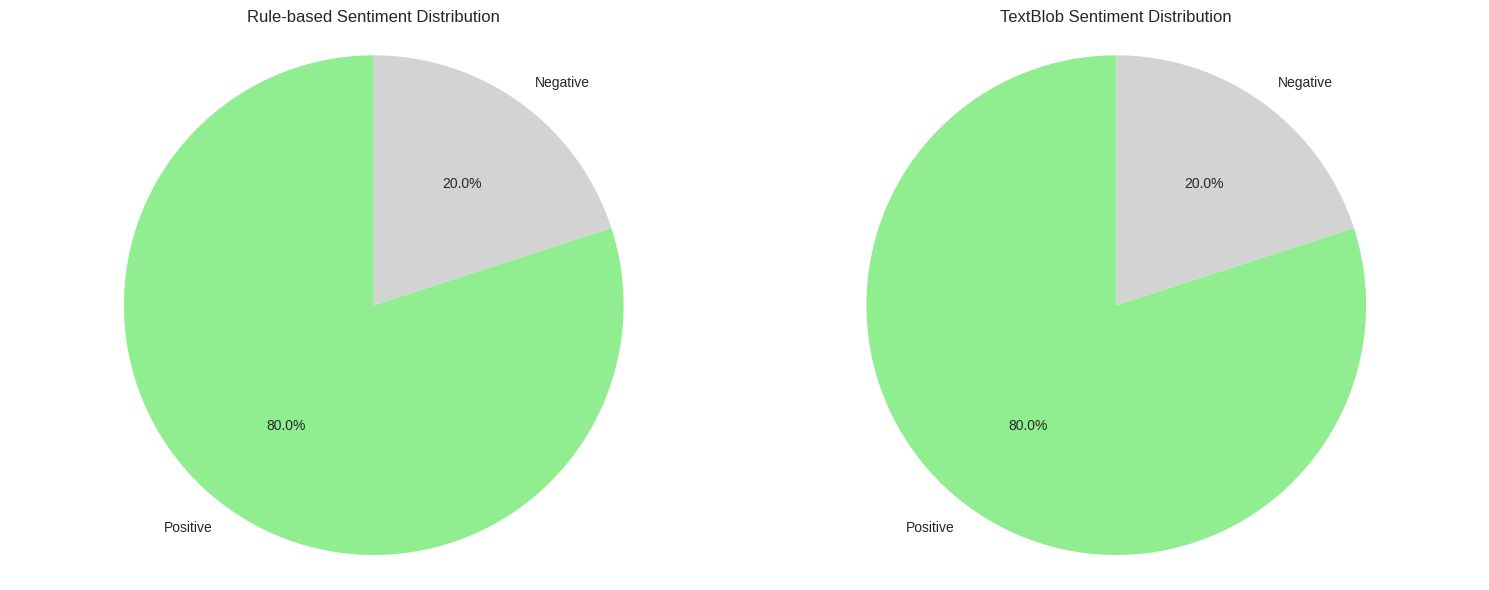

In [14]:
# Visualize sentiment distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Rule-based sentiment
labels = rule_counts.keys()
sizes = rule_counts.values()
colors = ['lightgreen', 'lightgray', 'salmon']
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
ax1.set_title('Rule-based Sentiment Distribution')

# TextBlob sentiment
labels = textblob_counts.keys()
sizes = textblob_counts.values()
ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.axis('equal')
ax2.set_title('TextBlob Sentiment Distribution')

plt.tight_layout()
plt.show()

## 8. Combined Analysis: Sentiment by Brand

Now let's combine our entity extraction and sentiment analysis to understand sentiment across different brands.

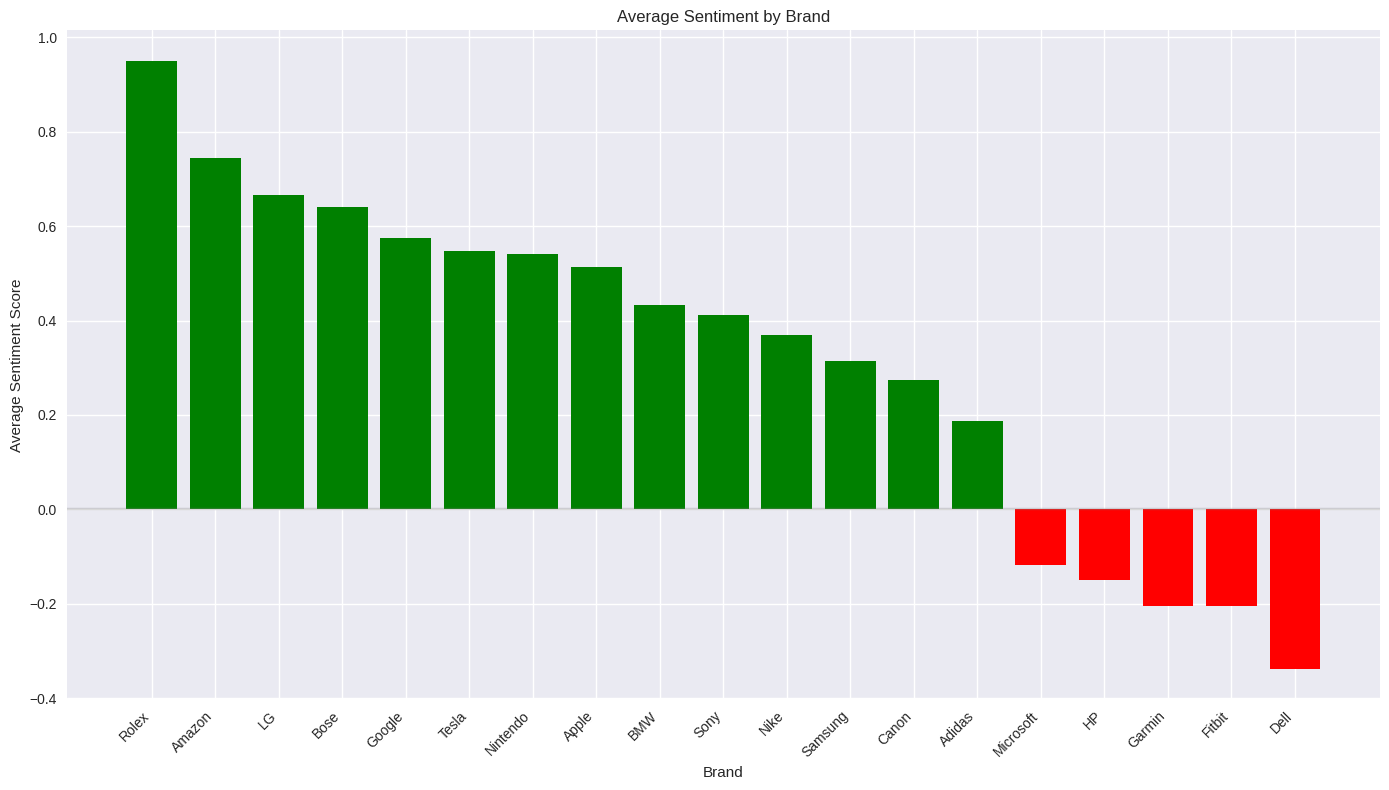

Brand Sentiment Analysis:
- Rolex: Positive (avg score: 0.950)
- Amazon: Positive (avg score: 0.744)
- LG: Positive (avg score: 0.667)
- Bose: Positive (avg score: 0.640)
- Google: Positive (avg score: 0.575)
- Tesla: Positive (avg score: 0.547)
- Nintendo: Positive (avg score: 0.540)
- Apple: Positive (avg score: 0.514)
- BMW: Positive (avg score: 0.433)
- Sony: Positive (avg score: 0.412)
- Nike: Positive (avg score: 0.368)
- Samsung: Positive (avg score: 0.315)
- Canon: Positive (avg score: 0.275)
- Adidas: Positive (avg score: 0.187)
- Microsoft: Negative (avg score: -0.117)
- HP: Negative (avg score: -0.150)
- Garmin: Negative (avg score: -0.204)
- Fitbit: Negative (avg score: -0.204)
- Dell: Negative (avg score: -0.338)


In [15]:
# Analyze sentiment by brand
brand_sentiment = defaultdict(list)

for i, row in reviews_df.iterrows():
    review_text = row['review_text'].lower()
    sentiment = row['sentiment']['textblob_polarity']
    
    for brand in all_brands:
        if brand.lower() in review_text:
            brand_sentiment[brand].append(sentiment)

# Calculate average sentiment for each brand
brand_avg_sentiment = {}
for brand, sentiments in brand_sentiment.items():
    if sentiments:  # Check if we have sentiments for this brand
        brand_avg_sentiment[brand] = sum(sentiments) / len(sentiments)

# Sort brands by average sentiment
sorted_brands = sorted(brand_avg_sentiment.items(), key=lambda x: x[1], reverse=True)

# Plot brand sentiment
plt.figure(figsize=(14, 8))
brands = [b[0] for b in sorted_brands]
sentiments = [b[1] for b in sorted_brands]

colors = ['green' if s > 0 else 'red' for s in sentiments]
plt.bar(brands, sentiments, color=colors)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.xlabel('Brand')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment by Brand')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print sentiment results by brand
print("Brand Sentiment Analysis:")
for brand, avg_sentiment in sorted_brands:
    sentiment_label = 'Positive' if avg_sentiment > 0.1 else 'Negative' if avg_sentiment < -0.1 else 'Neutral'
    print(f"- {brand}: {sentiment_label} (avg score: {avg_sentiment:.3f})")

## 9. Advanced Analysis: Product Features and Sentiment

Let's extract product features mentioned in reviews and analyze sentiment around these features.

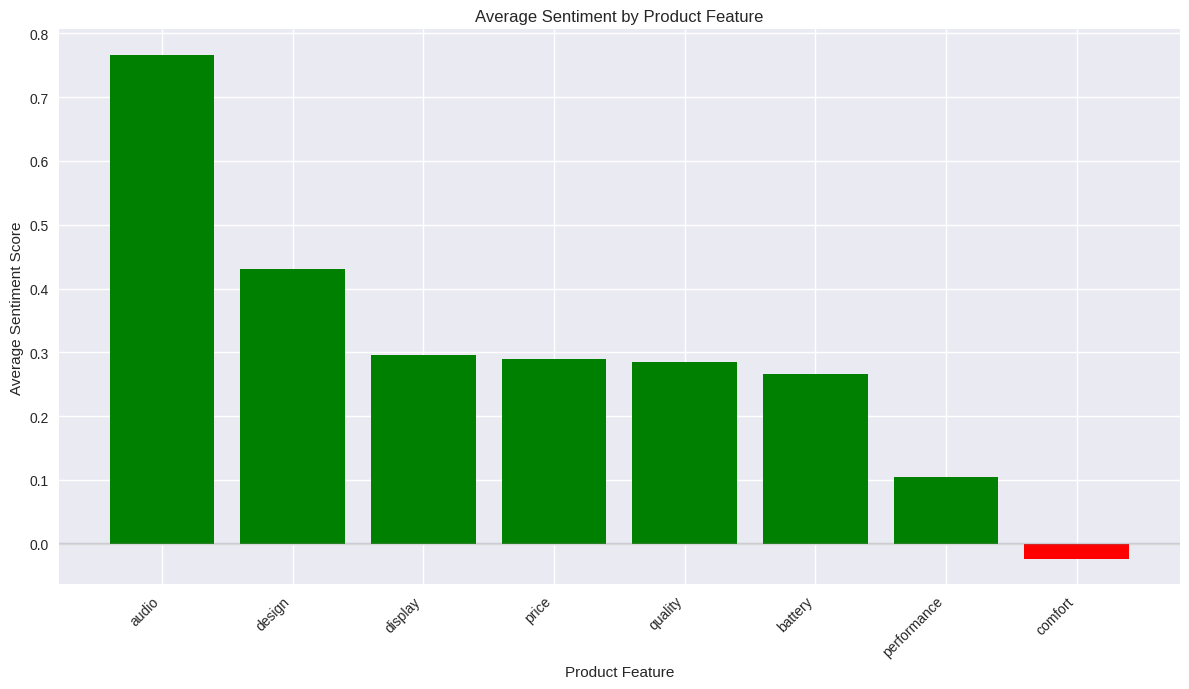

Product Feature Sentiment Analysis:
- audio: Positive (avg score: 0.767, mentions: 2)
- design: Positive (avg score: 0.431, mentions: 2)
- display: Positive (avg score: 0.296, mentions: 4)
- price: Positive (avg score: 0.290, mentions: 1)
- quality: Positive (avg score: 0.285, mentions: 8)
- battery: Positive (avg score: 0.267, mentions: 5)
- performance: Positive (avg score: 0.104, mentions: 4)
- comfort: Neutral (avg score: -0.024, mentions: 3)


In [16]:
# Define common product features
product_features = {
    'quality': ['quality', 'build', 'construction', 'durability'],
    'performance': ['performance', 'speed', 'fast', 'responsive', 'slow', 'lag'],
    'design': ['design', 'look', 'style', 'aesthetic', 'color'],
    'price': ['price', 'cost', 'expensive', 'cheap', 'affordable', 'value'],
    'battery': ['battery', 'charge', 'life', 'power'],
    'display': ['screen', 'display', 'resolution', 'bright', 'color'],
    'audio': ['sound', 'audio', 'speaker', 'noise', 'volume'],
    'comfort': ['comfort', 'comfortable', 'fit', 'ergonomic']
}

# Function to extract features and associated sentiment
def extract_feature_sentiment(text, doc=None):
    if doc is None:
        doc = nlp(text)
    
    feature_sentiments = defaultdict(list)
    
    # For each sentence in the document
    for sent in doc.sents:
        sent_text = sent.text.lower()
        
        # Check each feature category
        for feature_cat, feature_terms in product_features.items():
            for term in feature_terms:
                if term in sent_text:
                    # Calculate sentiment for this sentence
                    sent_sentiment = TextBlob(sent.text).sentiment.polarity
                    feature_sentiments[feature_cat].append(sent_sentiment)
                    break  # Once we find a term in a category, move to next category
    
    # Average sentiment for each feature category
    avg_feature_sentiment = {}
    for feature, sentiments in feature_sentiments.items():
        if sentiments:
            avg_feature_sentiment[feature] = sum(sentiments) / len(sentiments)
    
    return avg_feature_sentiment

# Apply feature sentiment extraction
reviews_df['feature_sentiment'] = reviews_df['review_text'].apply(extract_feature_sentiment)

# Aggregate feature sentiments across all reviews
all_feature_sentiment = defaultdict(list)
for feature_sent in reviews_df['feature_sentiment']:
    for feature, sentiment in feature_sent.items():
        all_feature_sentiment[feature].append(sentiment)

# Calculate average sentiment for each feature
avg_feature_sentiment = {}
for feature, sentiments in all_feature_sentiment.items():
    if sentiments:
        avg_feature_sentiment[feature] = sum(sentiments) / len(sentiments)
        
# Sort features by average sentiment
sorted_features = sorted(avg_feature_sentiment.items(), key=lambda x: x[1], reverse=True)

# Plot feature sentiment
plt.figure(figsize=(12, 7))
features = [f[0] for f in sorted_features]
sentiments = [f[1] for f in sorted_features]

colors = ['green' if s > 0 else 'red' for s in sentiments]
plt.bar(features, sentiments, color=colors)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.xlabel('Product Feature')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment by Product Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print feature sentiment results
print("Product Feature Sentiment Analysis:")
for feature, avg_sentiment in sorted_features:
    sentiment_label = 'Positive' if avg_sentiment > 0.1 else 'Negative' if avg_sentiment < -0.1 else 'Neutral'
    num_mentions = len(all_feature_sentiment[feature])
    print(f"- {feature}: {sentiment_label} (avg score: {avg_sentiment:.3f}, mentions: {num_mentions})")

## 10. Visualization Dashboard

Let's create a comprehensive dashboard that summarizes our findings.

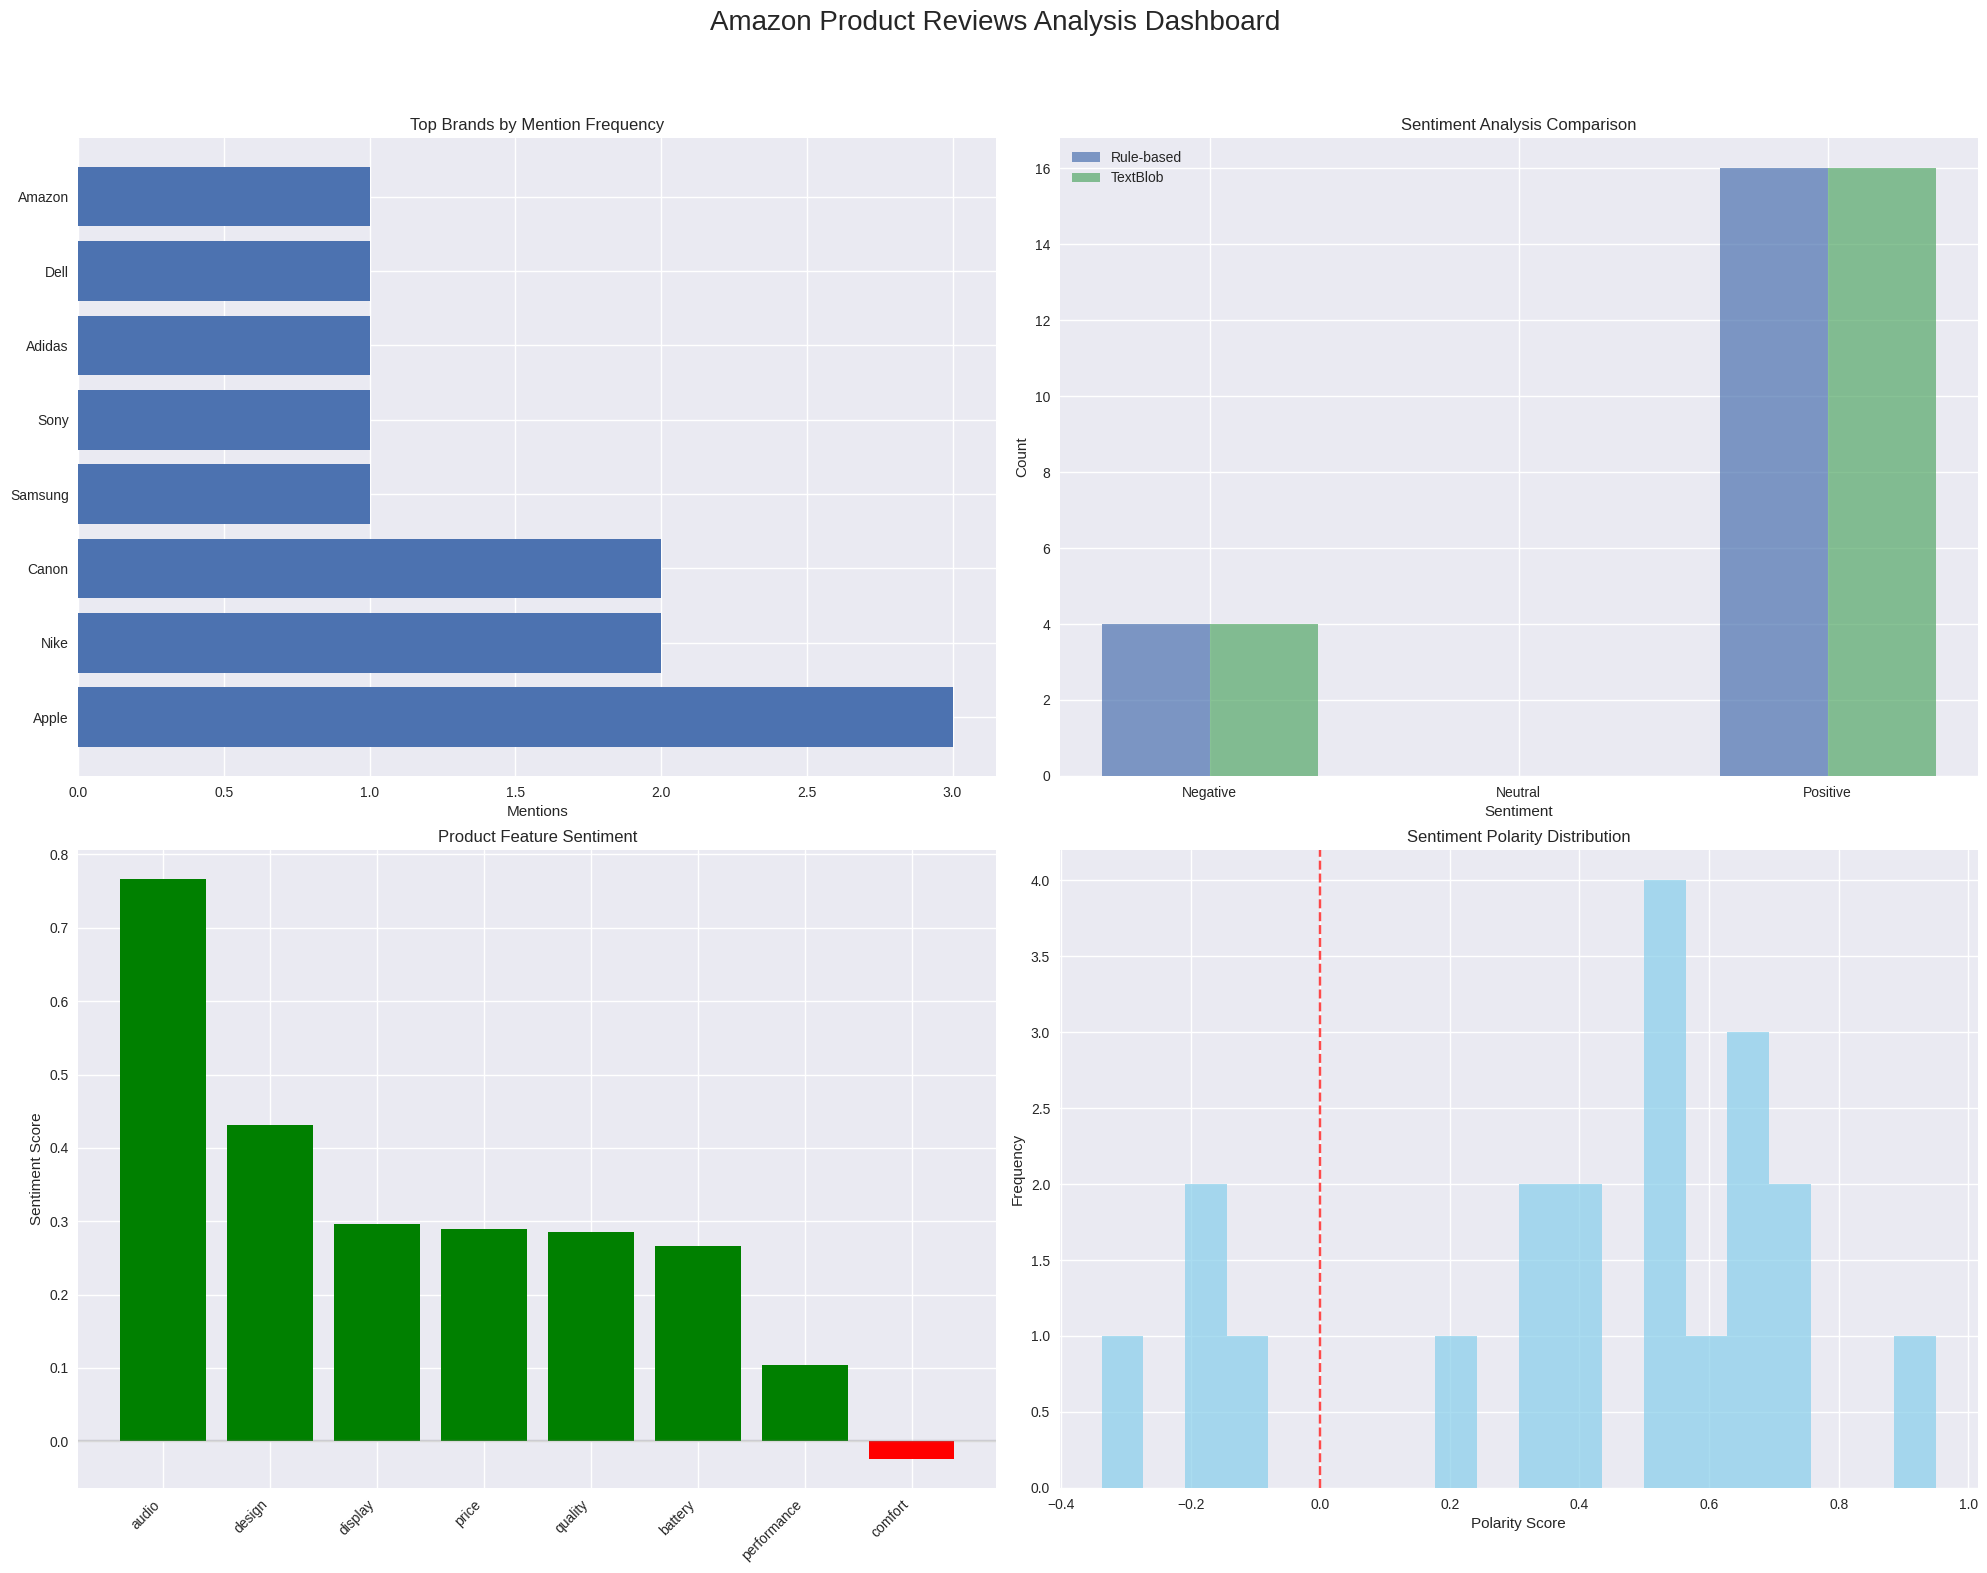

In [17]:
# Create a comprehensive visualization dashboard
plt.figure(figsize=(20, 16))

# 1. Top brands by mention frequency
plt.subplot(2, 2, 1)
brands, counts = zip(*brand_mentions.most_common(8))
plt.barh(range(len(brands)), counts, tick_label=brands)
plt.title('Top Brands by Mention Frequency')
plt.xlabel('Mentions')

# 2. Sentiment distribution comparison
plt.subplot(2, 2, 2)
x = np.arange(3)
width = 0.35

sentiments = ['Negative', 'Neutral', 'Positive']
rule_values = [rule_counts.get(s, 0) for s in sentiments]
textblob_values = [textblob_counts.get(s, 0) for s in sentiments]

plt.bar(x - width/2, rule_values, width, label='Rule-based', alpha=0.7)
plt.bar(x + width/2, textblob_values, width, label='TextBlob', alpha=0.7)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Analysis Comparison')
plt.xticks(x, sentiments)
plt.legend()

# 3. Feature sentiment analysis
plt.subplot(2, 2, 3)
features = [f[0] for f in sorted_features[:8]]  # Top 8 features
sentiments = [f[1] for f in sorted_features[:8]]
colors = ['green' if s > 0 else 'red' for s in sentiments]
plt.bar(features, sentiments, color=colors)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.title('Product Feature Sentiment')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45, ha='right')

# 4. Sentiment polarity distribution
plt.subplot(2, 2, 4)
polarities = [s['textblob_polarity'] for s in reviews_df['sentiment']]
plt.hist(polarities, bins=20, color='skyblue', alpha=0.7)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)

plt.suptitle('Amazon Product Reviews Analysis Dashboard', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## 11. Generate Analysis Report

Let's create a detailed report summarizing our findings.

In [18]:
# Generate most positive and negative reviews
polarities = [s['textblob_polarity'] for s in reviews_df['sentiment']]
most_positive_idx = polarities.index(max(polarities))
most_negative_idx = polarities.index(min(polarities))

# Most positive review
print("⭐ MOST POSITIVE REVIEW:")
print(f"Review ID: {reviews_df['review_id'][most_positive_idx]}")
print(f"Polarity: {polarities[most_positive_idx]:.3f}")
print(f"Text: {reviews_df['review_text'][most_positive_idx]}")

print("\n" + "-" * 50)

# Most negative review
print("\n⭐ MOST NEGATIVE REVIEW:")
print(f"Review ID: {reviews_df['review_id'][most_negative_idx]}")
print(f"Polarity: {polarities[most_negative_idx]:.3f}")
print(f"Text: {reviews_df['review_text'][most_negative_idx]}")

⭐ MOST POSITIVE REVIEW:
Review ID: 17
Polarity: 0.950
Text: The Rolex Submariner is a masterpiece! The craftsmanship is incredible and it keeps perfect time. Rolex is truly luxury at its finest.

--------------------------------------------------

⭐ MOST NEGATIVE REVIEW:
Review ID: 8
Polarity: -0.338
Text: The Dell laptop I bought has been disappointing. Poor build quality and the screen is not bright enough. Would not recommend Dell products.


In [19]:
# Generate comprehensive analysis report
print("=" * 50)
print("AMAZON PRODUCT REVIEWS NLP ANALYSIS REPORT")
print("=" * 50)

print("\n📊 DATASET SUMMARY:")
print(f"- Total reviews analyzed: {len(reviews_df)}")
print(f"- Average review length: {reviews_df['word_count'].mean():.1f} words")

print("\n📊 ENTITY EXTRACTION RESULTS:")
print(f"- Total entities found: {len(all_entities)}")
print(f"- Unique brands identified: {len(all_brands)}")
print(f"- Unique products identified: {len(all_products)}")
print(f"- Top 5 brands: {', '.join([b for b, _ in brand_mentions.most_common(5)])}")

print("\n📊 SENTIMENT ANALYSIS RESULTS:")
print("Rule-based Sentiment Analysis:")
for sentiment in ['Positive', 'Neutral', 'Negative']:
    count = rule_counts.get(sentiment, 0)
    percentage = count / len(reviews_df) * 100
    print(f"  - {sentiment}: {count} reviews ({percentage:.1f}%)")

print("\nTextBlob Sentiment Analysis:")
for sentiment in ['Positive', 'Neutral', 'Negative']:
    count = textblob_counts.get(sentiment, 0)
    percentage = count / len(reviews_df) * 100
    print(f"  - {sentiment}: {count} reviews ({percentage:.1f}%)")

print("\n📊 BRAND SENTIMENT HIGHLIGHTS:")
for brand, avg_sentiment in sorted_brands[:3]:  # Top 3 positive brands
    print(f"  - Most positive brand: {brand} (score: {avg_sentiment:.3f})")
    break
    
for brand, avg_sentiment in reversed(sorted_brands[-3:]):  # Top 3 negative brands
    print(f"  - Most negative brand: {brand} (score: {avg_sentiment:.3f})")
    break

print("\n📊 PRODUCT FEATURE INSIGHTS:")
for feature, avg_sentiment in sorted_features[:3]:  # Top 3 positive features
    print(f"  - Most positive feature: {feature} (score: {avg_sentiment:.3f})")
    break
    
for feature, avg_sentiment in reversed(sorted_features[-3:]):  # Top 3 negative features
    print(f"  - Most negative feature: {feature} (score: {avg_sentiment:.3f})")
    break

print("\n" + "=" * 50)
print("END OF REPORT")
print("=" * 50)

AMAZON PRODUCT REVIEWS NLP ANALYSIS REPORT

📊 DATASET SUMMARY:
- Total reviews analyzed: 20
- Average review length: 21.9 words

📊 ENTITY EXTRACTION RESULTS:
- Total entities found: 29
- Unique brands identified: 19
- Unique products identified: 20
- Top 5 brands: Apple, Nike, Canon, Samsung, Sony

📊 SENTIMENT ANALYSIS RESULTS:
Rule-based Sentiment Analysis:
  - Positive: 16 reviews (80.0%)
  - Neutral: 0 reviews (0.0%)
  - Negative: 4 reviews (20.0%)

TextBlob Sentiment Analysis:
  - Positive: 16 reviews (80.0%)
  - Neutral: 0 reviews (0.0%)
  - Negative: 4 reviews (20.0%)

📊 BRAND SENTIMENT HIGHLIGHTS:
  - Most positive brand: Rolex (score: 0.950)
  - Most negative brand: Dell (score: -0.338)

📊 PRODUCT FEATURE INSIGHTS:
  - Most positive feature: audio (score: 0.767)
  - Most negative feature: comfort (score: -0.024)

END OF REPORT


## 12. Conclusion

We've successfully performed named entity recognition and sentiment analysis on Amazon product reviews using spaCy and rule-based approaches.

### Summary of Achievements:
1. **Entity Extraction**:
   - Used spaCy's built-in NER to identify entities
   - Enhanced product and brand extraction with custom pattern matching
   - Identified key brands and products mentioned across reviews

2. **Sentiment Analysis**:
   - Implemented a rule-based sentiment analysis approach
   - Compared results with TextBlob's sentiment analysis
   - Analyzed sentiment by brand and product feature

3. **Insights Generation**:
   - Created visualizations to understand brand presence and sentiment
   - Identified most positive and negative brands
   - Analyzed sentiment around specific product features

### Limitations and Future Improvements:
1. **Enhanced NER**: Train a custom NER model specifically for product reviews
2. **Aspect-Based Sentiment Analysis**: More granular sentiment analysis for specific product aspects
3. **Larger Dataset**: Use a larger, more diverse dataset for better insights
4. **Advanced ML Approaches**: Implement transformer-based models (BERT, etc.) for improved results

### Business Value:
This analysis demonstrates how NLP can extract valuable insights from customer reviews, helping businesses:
- Identify strengths and weaknesses of products
- Compare brand perception against competitors
- Track sentiment across product features to guide improvements
- Monitor customer satisfaction and respond to issues

Overall, spaCy provides powerful NLP capabilities that can be enhanced with custom rules and approaches to gain valuable insights from customer feedback.